# Alarm Count Visualizations

The `alarm_data.csv` file contains all alarms of the cleaned CHARTEVENTS (`chartevents_clean.parquet`) and is available on the server in the folder `/data/alarms/`.

## Alarm Count by Vital Parameter and Alarm Type

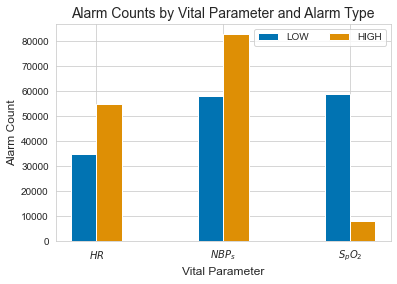

THRESHOLD_TYPE,HIGH,LOW
ITEMID_LABEL,,
$HR$,54891,34893
$NBP_s$,82830,58350
$S_pO_2$,8328,58999


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Read alarm data
alarm_data = pd.read_csv('../../data/alarms/alarm_data.csv')

# Add column for label of ITEMID
alarm_data.insert(loc=len(alarm_data.columns), column='ITEMID_LABEL', value=np.nan)
alarm_data.loc[alarm_data['ITEMID'] == 220045, 'ITEMID_LABEL'] = '$HR$'
alarm_data.loc[alarm_data['ITEMID'] == 220179, 'ITEMID_LABEL'] = '$NBP_s$'
alarm_data.loc[alarm_data['ITEMID'] == 220277, 'ITEMID_LABEL'] = '$S_pO_2$'

# Prepare plot data
alarms_by_itemid_type = alarm_data\
    .groupby(['ITEMID_LABEL', 'THRESHOLD_TYPE'])\
    .size()\
    .reset_index(name='AlarmCount')
alarms_by_itemid_type = alarms_by_itemid_type.pivot(index='ITEMID_LABEL', columns='THRESHOLD_TYPE', values='AlarmCount')

# Actual plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, figsize=(6, 4))
x = np.arange(len(alarms_by_itemid_type.index))
plt.bar(x - 0.1, alarms_by_itemid_type['LOW'], width=0.2, color=sns.color_palette('colorblind')[0])
plt.bar(x + 0.1, alarms_by_itemid_type['HIGH'], width=0.2, color=sns.color_palette('colorblind')[1]) #'#8390FA'
# Now we only use the colorblind palette for consistency reasons, but these are the original colour strings from our slides (see "Weekly_02", slide 7):
# LOW -> '#1D2F6F'
# HIGH -> '#8390FA'

# Add title, labels and legend
plt.title('Alarm Counts by Vital Parameter and Alarm Type', fontsize=14)
plt.xlabel('Vital Parameter', fontsize=12)
plt.ylabel('Alarm Count', fontsize=12)
plt.xticks(x, alarms_by_itemid_type.index)
plt.legend(['LOW', 'HIGH'], loc='upper right', ncol=2)

# Show figure and actual numbers
plt.show()
fig.savefig('../../plots/paper_alarm_counts_parameter_type.pdf')
alarms_by_itemid_type

## Alarm Counts per ICU Stay ID

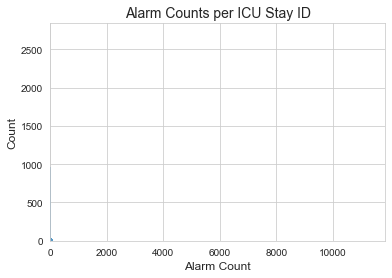

On average there are about 16 alarms per ICU stay.

There are 2703 out of 18834 ICU stays with only one alarm.

Most of the ICU stays have between 3 (25th percentile) and 16 (75th percentile) alarms.

There are 189 outliers (over 99.0th percentile), with 11289 alarms being the maximum for one single ICU stay.



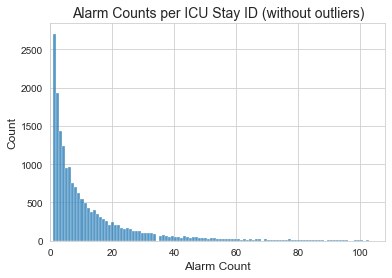

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Read alarm data
alarm_data = pd.read_csv('../../data/alarms/alarm_data.csv')

# Prepare plot data
alarms_by_icustay = alarm_data\
    .groupby(['ICUSTAY_ID'])\
    .size()\
    .reset_index(name='AlarmCount')

# Actual plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, figsize=(6, 4))
sns.histplot(data=alarms_by_icustay, x='AlarmCount', palette=sns.color_palette('colorblind'))

# Add title and adjust axes
plt.title('Alarm Counts per ICU Stay ID', fontsize=14)
plt.xlabel('Alarm Count', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(left=0)

# Show figure and print some insights
plt.show()
print(f'On average there are about {round(alarms_by_icustay.AlarmCount.mean())} alarms per ICU stay.\n')
print(f'There are {(alarms_by_icustay.AlarmCount.values == 1).sum()} out of {len(alarms_by_icustay)} ICU stays with only one alarm.\n')
print(f'Most of the ICU stays have between {round(alarms_by_icustay.AlarmCount.quantile(.25))} (25th percentile) and {round(alarms_by_icustay.AlarmCount.quantile(.75))} (75th percentile) alarms.\n')

# Note: We did not use percentiles to identify outliers for the plot in our slides (see "Weekly_02", slide 8)
outlier_percentile = .99
num_outliers = len(alarms_by_icustay[alarms_by_icustay.AlarmCount > alarms_by_icustay.AlarmCount.quantile(outlier_percentile)])
print(f'There are {num_outliers} outliers (over {outlier_percentile*100}th percentile), with {alarms_by_icustay.AlarmCount.max()} alarms being the maximum for one single ICU stay.\n')

# Plot alarm count per ICU stay without outliers (to have a more useful plot)
if num_outliers > 0:
    alarms_by_icustay_without_outliers = alarms_by_icustay[alarms_by_icustay.AlarmCount <= alarms_by_icustay.AlarmCount.quantile(outlier_percentile)]

    # Actual plot
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, figsize=(6, 4))
    sns.histplot(data=alarms_by_icustay_without_outliers, x='AlarmCount', palette=sns.color_palette('colorblind'))

    # Add title and adjust axes
    plt.title('Alarm Counts per ICU Stay ID (without outliers)', fontsize=14)
    plt.xlabel('Alarm Count', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xlim(left=0)

    # Show figure
    plt.show()
    fig.savefig('../../plots/paper_alarm_counts_icu_stay.pdf')